In [10]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torchvision
from torchvision import transforms
import sys
import os, json, glob
from pathlib import Path
path = str(Path(os.path.join('..','src','elohim','elohim')).resolve())
if path not in sys.path:
    sys.path.insert(0,path)
from utils import cv_from_binary

import pandas as pd
import numpy as np
import re

In [14]:
ds = [d for d in sorted(os.scandir(os.path.join('..','history')), key=lambda x:x.path, reverse=False) if re.match(r'(.*?)[0-9]{4}-[0-9]{6}', d.path) is not None]
print([d.path for d in ds])
d = ds[-1]
data_path = os.path.join(d.path, 'dataset.pkl')
if os.path.exists(data_path):
    print(f'The most recent simulation folder has been selected "{d.path}":')
    df = pd.read_pickle(data_path)
    dataset = df[['image','target_map']]
    dataset.head()

['../history/1205-002637', '../history/1230-010144', '../history/1230-192402', '../history/1231-000050', '../history/1231-001235', '../history/1231-001724', '../history/1231-002801']
The most recent simulation folder has been selected "../history/1231-002801":


In [77]:
a = torch.rand((3,3))
a, torch.flip(a, dims=[1])

(tensor([[0.4657, 0.8766, 0.3699],
         [0.4677, 0.5987, 0.6942],
         [0.2855, 0.9034, 0.9600]]),
 tensor([[0.3699, 0.8766, 0.4657],
         [0.6942, 0.5987, 0.4677],
         [0.9600, 0.9034, 0.2855]]))

## ML Dataset

In [43]:
def _moveaxis(tensor: torch.Tensor, source: int, destination: int) -> torch.Tensor:
    dim = tensor.dim()
    perm = list(range(dim))
    if destination < 0:
        destination += dim
    perm.pop(source)
    perm.insert(destination, source)
    return tensor.permute(*perm)

In [54]:
import dataset_ml, importlib
importlib.reload(dataset_ml)
from dataset_ml import get_dataset
(train_loader, val_loader, test_loader), test_dataset = get_dataset(d.path, batch_size=500)


Loading splits pickles into memory: 100%|██████████| 3/3 [00:11<00:00,  3.94s/it]


Batches per split: 386,49,49
Datasets x,y shapes [500, 3, 240, 320],[500, 400]


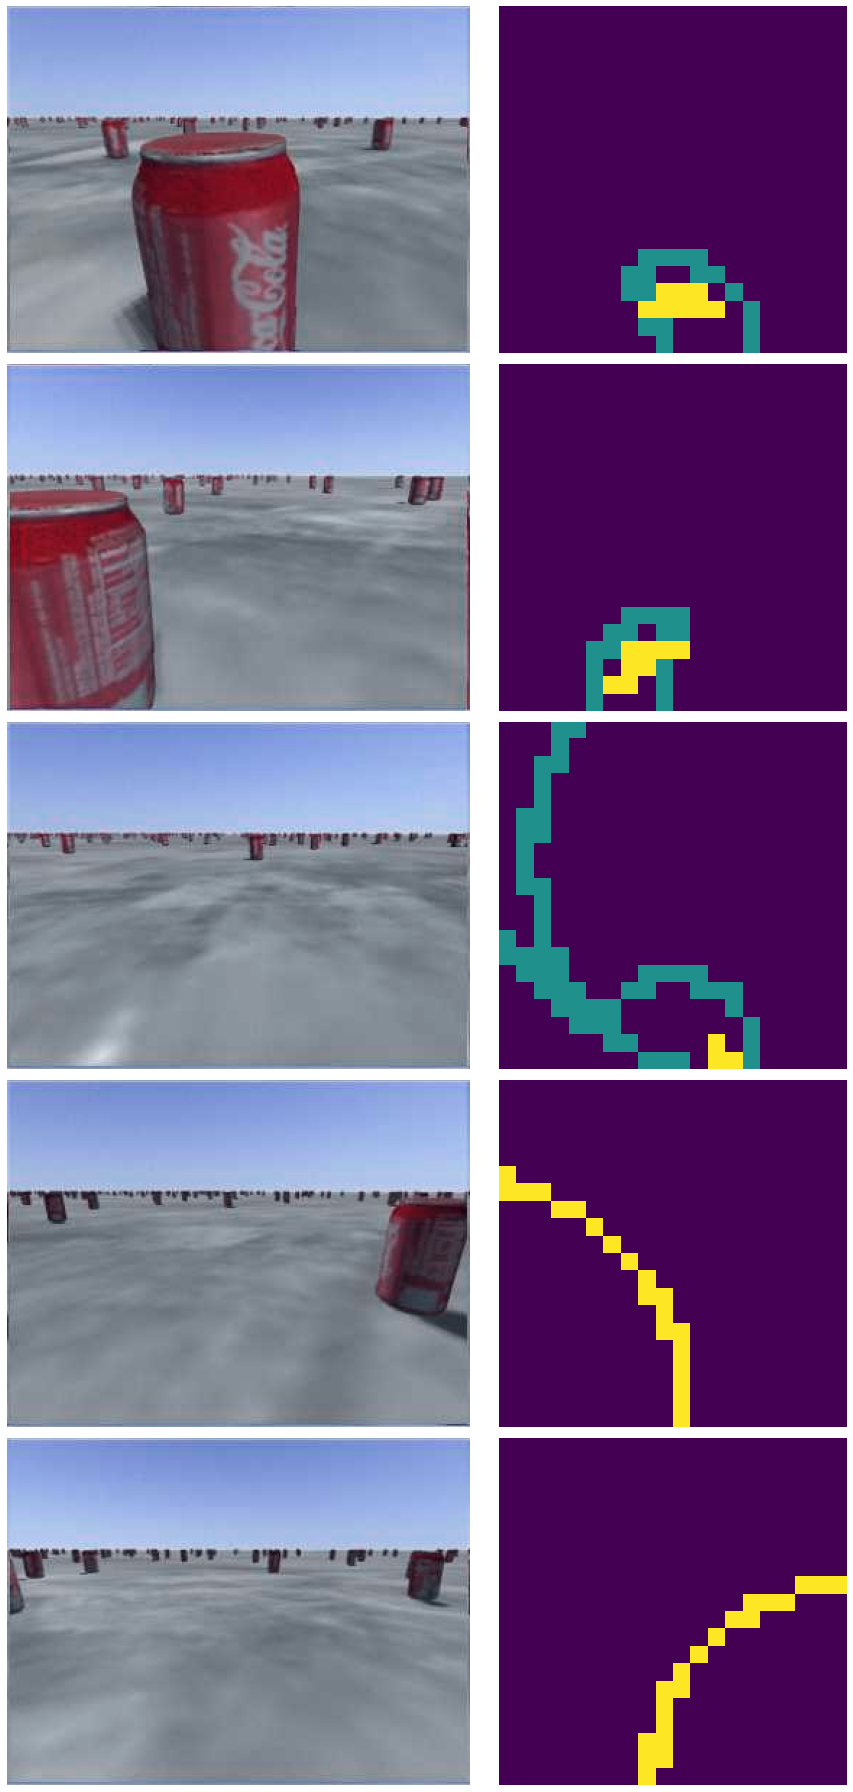

In [70]:
import matplotlib.pyplot as plt
n = 5
fig, axs = plt.subplots(n,2, figsize=(13,5*n))
x = iter(train_loader)
next(x)
next(x)
next(x)
X, y = next(x)
step = 2
for i, (X, y) in enumerate(zip(X[:n*step:step],y[:n*step:step])):
    
    X = _moveaxis(X,0,-1)
    X = (X - X.min())/(X.max()-X.min())
    axs[i,0].imshow(X)
#     axs[i+0].set_title(f'ML ready format: [{X.min():1.1f},{X.max():1.1f}]\nnormalizing with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]'+\
#                      f'\n(here showing only "visible" [0,1] neighbourhood)')
    axs[i,0].axis('off')
    axs[i,1].imshow(y.reshape(20,20))
    axs[i,1].axis('off')

plt.tight_layout()
#plt.suptitle('Very first image of train split ([C,H,W]->[H,W,C] axis flip for display purposes)', y=1.07)

plt.show()

In [14]:
train_loader.dataset[0][0].shape


torch.Size([3, 240, 320])

In [29]:
x = np.random.uniform(0,1,size=(16,400))
np.dstack([1-x, x]).shape

(16, 400, 2)

# Models

### Pretrained MobileNetV2 (frozen convolutional layers)

In [5]:
import torch
device = 'cpu'
model = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
model.to(device)
display(list(model._modules.keys()))
for param in model.features.parameters():
    param.requires_grad = False
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 400)
)

Using cache found in /Users/ste/.cache/torch/hub/pytorch_vision_master


['features', 'classifier']

In [72]:
import model, dataset_ml, training
importlib.reload(model)
importlib.reload(dataset_ml)
importlib.reload(training)
from model import BayesConvNet, ConvNet
from dataset_ml import get_dataset
from training import train_val_test

irs = [[1, 16, 1, 1],
           [6, 24, 2, 2],
           [6, 32, 3, 2],
           [6, 96, 1, 1]]
common_parameters = {'inverted_residual_setting': irs, 'in_planes': 200,
                     'out_planes': 400, 'num_classes': 400, 'mode': 'softmax'}

bayes = False
if bayes:
    model = BayesConvNet(samples=args.samples, **common_parameters)
else:
    model = ConvNet(**common_parameters)

torch_dataset = get_dataset(dataset=dataset, tr_val_split=[0.8, 0.1], batch_size=16, dataset_max_size=160)
train_metrics, val_metrics, test_metrics = train_val_test(model, device, dataset=torch_dataset, bayes=bayes, patience=3, epochs=5)

Softmax function has been appended


  0%|          | 0/8 [00:00<?, ?it/s]

Dataset size reduced (231818 -> (160))
Batches per split: 8,1,1
Dataset, x,y shapes:  [16, 3, 240, 320],[16, 400]
Animals/colors .txt files not found in /utils/*, using hardcoded combinations
New training session, code name: red-maverick (path: 1211-0113_red-maverick.pt)


 12%|█▎        | 1/8 [00:05<00:38,  5.46s/it]

Training Epoch: 1 [16/128 (12%)]	Loss: 0.686561		AUC: 0.561

 25%|██▌       | 2/8 [00:10<00:32,  5.34s/it]

Training Epoch: 1 [32/128 (25%)]	Loss: 0.691495		AUC: 0.475

 38%|███▊      | 3/8 [00:15<00:26,  5.27s/it]

Training Epoch: 1 [48/128 (38%)]	Loss: 0.685777		AUC: 0.554

 50%|█████     | 4/8 [00:21<00:21,  5.36s/it]

Training Epoch: 1 [64/128 (50%)]	Loss: 0.679633		AUC: 0.628

 62%|██████▎   | 5/8 [00:26<00:16,  5.35s/it]

Training Epoch: 1 [80/128 (62%)]	Loss: 0.697102		AUC: 0.450

 75%|███████▌  | 6/8 [00:31<00:10,  5.30s/it]

Training Epoch: 1 [96/128 (75%)]	Loss: 0.689552		AUC: 0.505

 88%|████████▊ | 7/8 [00:36<00:05,  5.26s/it]

Training Epoch: 1 [112/128 (88%)]	Loss: 0.688389		AUC: 0.512

100%|██████████| 8/8 [00:41<00:00,  5.25s/it]

Training Epoch: 1 [128/128 (100%)]	Loss: 0.696474		AUC: 0.458


  0%|          | 0/8 [00:00<?, ?it/s]

Validation Epoch: 1 [16/16 (100%)]	Loss: 0.689275		AUC: 0.549
[ 0/10] train_loss: 0.68937 valid_loss: 0.68928
Validation loss decreased (inf --> 0.689275).  Saving model ...


 12%|█▎        | 1/8 [00:05<00:35,  5.07s/it]

Training Epoch: 2 [16/128 (12%)]	Loss: 0.695650		AUC: 0.505

 25%|██▌       | 2/8 [00:10<00:30,  5.08s/it]

Training Epoch: 2 [32/128 (25%)]	Loss: 0.692721		AUC: 0.486

 38%|███▊      | 3/8 [00:15<00:25,  5.09s/it]

Training Epoch: 2 [48/128 (38%)]	Loss: 0.688749		AUC: 0.508

 50%|█████     | 4/8 [00:20<00:20,  5.09s/it]

Training Epoch: 2 [64/128 (50%)]	Loss: 0.690213		AUC: 0.496

 62%|██████▎   | 5/8 [00:25<00:15,  5.09s/it]

Training Epoch: 2 [80/128 (62%)]	Loss: 0.694577		AUC: 0.519

 75%|███████▌  | 6/8 [00:30<00:10,  5.10s/it]

Training Epoch: 2 [96/128 (75%)]	Loss: 0.687909		AUC: 0.525

 88%|████████▊ | 7/8 [00:35<00:05,  5.10s/it]

Training Epoch: 2 [112/128 (88%)]	Loss: 0.683672		AUC: 0.593

100%|██████████| 8/8 [00:40<00:00,  5.09s/it]

Training Epoch: 2 [128/128 (100%)]	Loss: 0.681579		AUC: 0.590


  0%|          | 0/8 [00:00<?, ?it/s]

Validation Epoch: 2 [16/16 (100%)]	Loss: 0.690441		AUC: 0.555
[ 1/10] train_loss: 0.68938 valid_loss: 0.69044
EarlyStopping counter: 1 out of 20


 12%|█▎        | 1/8 [00:05<00:35,  5.13s/it]

Training Epoch: 3 [16/128 (12%)]	Loss: 0.681391		AUC: 0.604

 25%|██▌       | 2/8 [00:10<00:30,  5.11s/it]

Training Epoch: 3 [32/128 (25%)]	Loss: 0.693895		AUC: 0.456

 38%|███▊      | 3/8 [00:15<00:26,  5.20s/it]

Training Epoch: 3 [48/128 (38%)]	Loss: 0.684861		AUC: 0.565

 50%|█████     | 4/8 [00:20<00:20,  5.25s/it]

Training Epoch: 3 [64/128 (50%)]	Loss: 0.683657		AUC: 0.562

 62%|██████▎   | 5/8 [00:26<00:15,  5.27s/it]

Training Epoch: 3 [80/128 (62%)]	Loss: 0.693124		AUC: 0.466

 75%|███████▌  | 6/8 [00:31<00:10,  5.26s/it]

Training Epoch: 3 [96/128 (75%)]	Loss: 0.688134		AUC: 0.533

 88%|████████▊ | 7/8 [00:36<00:05,  5.20s/it]

Training Epoch: 3 [112/128 (88%)]	Loss: 0.687450		AUC: 0.550

100%|██████████| 8/8 [00:41<00:00,  5.20s/it]

Training Epoch: 3 [128/128 (100%)]	Loss: 0.689852		AUC: 0.528


  0%|          | 0/8 [00:00<?, ?it/s]

Validation Epoch: 3 [16/16 (100%)]	Loss: 0.690823		AUC: 0.558
[ 2/10] train_loss: 0.68780 valid_loss: 0.69082
EarlyStopping counter: 2 out of 20


 12%|█▎        | 1/8 [00:05<00:36,  5.18s/it]

Training Epoch: 4 [16/128 (12%)]	Loss: 0.698066		AUC: 0.456

 25%|██▌       | 2/8 [00:10<00:31,  5.17s/it]

Training Epoch: 4 [32/128 (25%)]	Loss: 0.680344		AUC: 0.620

 38%|███▊      | 3/8 [00:15<00:25,  5.19s/it]

Training Epoch: 4 [48/128 (38%)]	Loss: 0.697786		AUC: 0.418

 50%|█████     | 4/8 [00:20<00:20,  5.24s/it]

Training Epoch: 4 [64/128 (50%)]	Loss: 0.685516		AUC: 0.567

 62%|██████▎   | 5/8 [00:26<00:15,  5.22s/it]

Training Epoch: 4 [80/128 (62%)]	Loss: 0.691630		AUC: 0.497

 75%|███████▌  | 6/8 [00:31<00:10,  5.17s/it]

Training Epoch: 4 [96/128 (75%)]	Loss: 0.682430		AUC: 0.584

 88%|████████▊ | 7/8 [00:36<00:05,  5.12s/it]

Training Epoch: 4 [112/128 (88%)]	Loss: 0.688534		AUC: 0.523

100%|██████████| 8/8 [00:41<00:00,  5.15s/it]

Training Epoch: 4 [128/128 (100%)]	Loss: 0.680075		AUC: 0.615


  0%|          | 0/8 [00:00<?, ?it/s]

Validation Epoch: 4 [16/16 (100%)]	Loss: 0.690461		AUC: 0.555
[ 3/10] train_loss: 0.68805 valid_loss: 0.69046
EarlyStopping counter: 3 out of 20


 12%|█▎        | 1/8 [00:05<00:35,  5.02s/it]

Training Epoch: 5 [16/128 (12%)]	Loss: 0.689361		AUC: 0.561

 25%|██▌       | 2/8 [00:10<00:30,  5.06s/it]

Training Epoch: 5 [32/128 (25%)]	Loss: 0.685713		AUC: 0.521

 38%|███▊      | 3/8 [00:15<00:25,  5.15s/it]

Training Epoch: 5 [48/128 (38%)]	Loss: 0.685113		AUC: 0.561

 50%|█████     | 4/8 [00:20<00:20,  5.16s/it]

Training Epoch: 5 [64/128 (50%)]	Loss: 0.682005		AUC: 0.591

 62%|██████▎   | 5/8 [00:26<00:15,  5.22s/it]

Training Epoch: 5 [80/128 (62%)]	Loss: 0.690426		AUC: 0.509

 75%|███████▌  | 6/8 [00:31<00:10,  5.33s/it]

Training Epoch: 5 [96/128 (75%)]	Loss: 0.694521		AUC: 0.459

 88%|████████▊ | 7/8 [00:36<00:05,  5.32s/it]

Training Epoch: 5 [112/128 (88%)]	Loss: 0.684045		AUC: 0.565

100%|██████████| 8/8 [00:42<00:00,  5.27s/it]

Training Epoch: 5 [128/128 (100%)]	Loss: 0.687456		AUC: 0.562


  0%|          | 0/8 [00:00<?, ?it/s]

Validation Epoch: 5 [16/16 (100%)]	Loss: 0.689385		AUC: 0.576
[ 4/10] train_loss: 0.68733 valid_loss: 0.68938
EarlyStopping counter: 4 out of 20


 12%|█▎        | 1/8 [00:05<00:36,  5.15s/it]

Training Epoch: 6 [16/128 (12%)]	Loss: 0.687576		AUC: 0.505

 25%|██▌       | 2/8 [00:10<00:31,  5.20s/it]

Training Epoch: 6 [32/128 (25%)]	Loss: 0.689700		AUC: 0.499

 38%|███▊      | 3/8 [00:15<00:26,  5.21s/it]

Training Epoch: 6 [48/128 (38%)]	Loss: 0.685502		AUC: 0.551

 50%|█████     | 4/8 [00:20<00:20,  5.19s/it]

Training Epoch: 6 [64/128 (50%)]	Loss: 0.687646		AUC: 0.542

 62%|██████▎   | 5/8 [00:26<00:15,  5.19s/it]

Training Epoch: 6 [80/128 (62%)]	Loss: 0.696980		AUC: 0.419

 75%|███████▌  | 6/8 [00:31<00:10,  5.19s/it]

Training Epoch: 6 [96/128 (75%)]	Loss: 0.684034		AUC: 0.574

 88%|████████▊ | 7/8 [00:36<00:05,  5.19s/it]

Training Epoch: 6 [112/128 (88%)]	Loss: 0.684780		AUC: 0.555

100%|██████████| 8/8 [00:41<00:00,  5.20s/it]

Training Epoch: 6 [128/128 (100%)]	Loss: 0.682010		AUC: 0.602


  0%|          | 0/8 [00:00<?, ?it/s]

Validation Epoch: 6 [16/16 (100%)]	Loss: 0.687416		AUC: 0.593
[ 5/10] train_loss: 0.68728 valid_loss: 0.68742
Validation loss decreased (0.689275 --> 0.687416).  Saving model ...


 12%|█▎        | 1/8 [00:05<00:38,  5.45s/it]

Training Epoch: 7 [16/128 (12%)]	Loss: 0.684283		AUC: 0.566

 25%|██▌       | 2/8 [00:10<00:32,  5.39s/it]

Training Epoch: 7 [32/128 (25%)]	Loss: 0.683897		AUC: 0.603

 38%|███▊      | 3/8 [00:15<00:26,  5.34s/it]

Training Epoch: 7 [48/128 (38%)]	Loss: 0.675895		AUC: 0.652

 50%|█████     | 4/8 [00:21<00:21,  5.29s/it]

Training Epoch: 7 [64/128 (50%)]	Loss: 0.683877		AUC: 0.573

 62%|██████▎   | 5/8 [00:26<00:15,  5.28s/it]

Training Epoch: 7 [80/128 (62%)]	Loss: 0.691221		AUC: 0.491

 75%|███████▌  | 6/8 [00:31<00:10,  5.25s/it]

Training Epoch: 7 [96/128 (75%)]	Loss: 0.689973		AUC: 0.530

 88%|████████▊ | 7/8 [00:36<00:05,  5.23s/it]

Training Epoch: 7 [112/128 (88%)]	Loss: 0.697157		AUC: 0.419

100%|██████████| 8/8 [00:41<00:00,  5.24s/it]

Training Epoch: 7 [128/128 (100%)]	Loss: 0.688901		AUC: 0.480


  0%|          | 0/8 [00:00<?, ?it/s]

Validation Epoch: 7 [16/16 (100%)]	Loss: 0.684620		AUC: 0.597
[ 6/10] train_loss: 0.68690 valid_loss: 0.68462
Validation loss decreased (0.687416 --> 0.684620).  Saving model ...


 12%|█▎        | 1/8 [00:05<00:36,  5.15s/it]

Training Epoch: 8 [16/128 (12%)]	Loss: 0.689973		AUC: 0.495

 25%|██▌       | 2/8 [00:10<00:30,  5.15s/it]

Training Epoch: 8 [32/128 (25%)]	Loss: 0.682261		AUC: 0.569

 38%|███▊      | 3/8 [00:15<00:25,  5.16s/it]

Training Epoch: 8 [48/128 (38%)]	Loss: 0.695483		AUC: 0.476

 50%|█████     | 4/8 [00:20<00:20,  5.15s/it]

Training Epoch: 8 [64/128 (50%)]	Loss: 0.696805		AUC: 0.466

 62%|██████▎   | 5/8 [00:25<00:15,  5.14s/it]

Training Epoch: 8 [80/128 (62%)]	Loss: 0.681549		AUC: 0.564

 75%|███████▌  | 6/8 [00:30<00:10,  5.12s/it]

Training Epoch: 8 [96/128 (75%)]	Loss: 0.690295		AUC: 0.510

 88%|████████▊ | 7/8 [00:35<00:05,  5.13s/it]

Training Epoch: 8 [112/128 (88%)]	Loss: 0.681050		AUC: 0.586

100%|██████████| 8/8 [00:41<00:00,  5.14s/it]

Training Epoch: 8 [128/128 (100%)]	Loss: 0.679906		AUC: 0.599


  0%|          | 0/8 [00:00<?, ?it/s]

Validation Epoch: 8 [16/16 (100%)]	Loss: 0.682719		AUC: 0.606
[ 7/10] train_loss: 0.68717 valid_loss: 0.68272
Validation loss decreased (0.684620 --> 0.682719).  Saving model ...


 12%|█▎        | 1/8 [00:05<00:35,  5.02s/it]

Training Epoch: 9 [16/128 (12%)]	Loss: 0.689756		AUC: 0.508

 25%|██▌       | 2/8 [00:10<00:30,  5.07s/it]

Training Epoch: 9 [32/128 (25%)]	Loss: 0.687948		AUC: 0.531

 38%|███▊      | 3/8 [00:15<00:25,  5.10s/it]

Training Epoch: 9 [48/128 (38%)]	Loss: 0.691532		AUC: 0.503

 50%|█████     | 4/8 [00:20<00:20,  5.14s/it]

Training Epoch: 9 [64/128 (50%)]	Loss: 0.690124		AUC: 0.539

 62%|██████▎   | 5/8 [00:25<00:15,  5.17s/it]

Training Epoch: 9 [80/128 (62%)]	Loss: 0.698933		AUC: 0.443

 75%|███████▌  | 6/8 [00:31<00:10,  5.19s/it]

Training Epoch: 9 [96/128 (75%)]	Loss: 0.693730		AUC: 0.483

 88%|████████▊ | 7/8 [00:36<00:05,  5.25s/it]

Training Epoch: 9 [112/128 (88%)]	Loss: 0.680273		AUC: 0.625

100%|██████████| 8/8 [00:41<00:00,  5.23s/it]

Training Epoch: 9 [128/128 (100%)]	Loss: 0.687002		AUC: 0.550


  0%|          | 0/8 [00:00<?, ?it/s]

Validation Epoch: 9 [16/16 (100%)]	Loss: 0.682818		AUC: 0.604
[ 8/10] train_loss: 0.68991 valid_loss: 0.68282
EarlyStopping counter: 1 out of 20


 12%|█▎        | 1/8 [00:05<00:35,  5.13s/it]

Training Epoch: 10 [16/128 (12%)]	Loss: 0.693370		AUC: 0.496

 25%|██▌       | 2/8 [00:10<00:30,  5.15s/it]

Training Epoch: 10 [32/128 (25%)]	Loss: 0.690071		AUC: 0.489

 38%|███▊      | 3/8 [00:15<00:25,  5.13s/it]

Training Epoch: 10 [48/128 (38%)]	Loss: 0.688954		AUC: 0.529

 50%|█████     | 4/8 [00:20<00:20,  5.11s/it]

Training Epoch: 10 [64/128 (50%)]	Loss: 0.687674		AUC: 0.542

 62%|██████▎   | 5/8 [00:25<00:15,  5.11s/it]

Training Epoch: 10 [80/128 (62%)]	Loss: 0.684882		AUC: 0.558

 75%|███████▌  | 6/8 [00:31<00:10,  5.24s/it]

Training Epoch: 10 [96/128 (75%)]	Loss: 0.696930		AUC: 0.504

 88%|████████▊ | 7/8 [00:36<00:05,  5.18s/it]

Training Epoch: 10 [112/128 (88%)]	Loss: 0.686194		AUC: 0.523

100%|██████████| 8/8 [00:41<00:00,  5.15s/it]

Training Epoch: 10 [128/128 (100%)]	Loss: 0.683562		AUC: 0.589

Validation Epoch: 10 [16/16 (100%)]	Loss: 0.683701		AUC: 0.597
[ 9/10] train_loss: 0.68895 valid_loss: 0.68370
EarlyStopping counter: 2 out of 20
Testing
Test  [16/16 (100%)]	Loss: 0.689902		AUC: 0.562

(3, 3)


Text(0.5, 1.03, 'test')

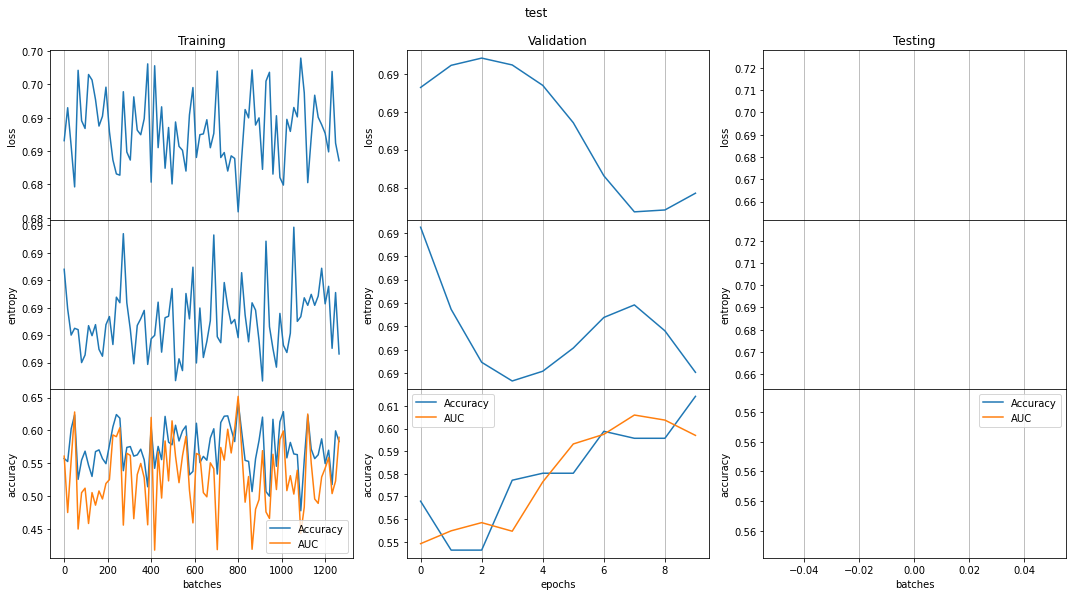

In [148]:

import seaborn as sns
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter

fig, axs = plt.subplots(3, 3, figsize=(15, 8), sharex='col')
axs = np.array(axs)
print(axs.shape)
def plot(title, axs, metrics, bs=None, xlabel='batches'):
    if bs is None:
        bs = batch_size
    
    df = pd.DataFrame(metrics, index=np.arange(0, len(metrics) * bs, bs), columns=['loss', 'entropy', 'accuracy', 'auc'])
    sns.lineplot(data=df['loss'], ax=axs[0])
    axs[0].set_title(title)
    sns.lineplot(data=df['entropy'], ax=axs[1])
    sns.lineplot(data=df['accuracy'], ax=axs[2], label='Accuracy')
    sns.lineplot(data=df['auc'], ax=axs[2], label='AUC')
    axs[2].set_xlabel(xlabel)
    #[ax.xaxis.set_minor_locator(MultipleLocator(base=bs)) for ax in axs]
    for ax in axs:
        ax.grid(axis='x', which='major', linestyle='-')
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plot('Training',axs[:,0], train_metrics.copy())
plot('Validation',axs[:,1], val_metrics.copy(), bs=1, xlabel='epochs')
plot('Testing',axs[:,2], test_metrics.copy())
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.suptitle('test', y=1.03)


ValueError: 2 columns passed, passed data had 4 columns

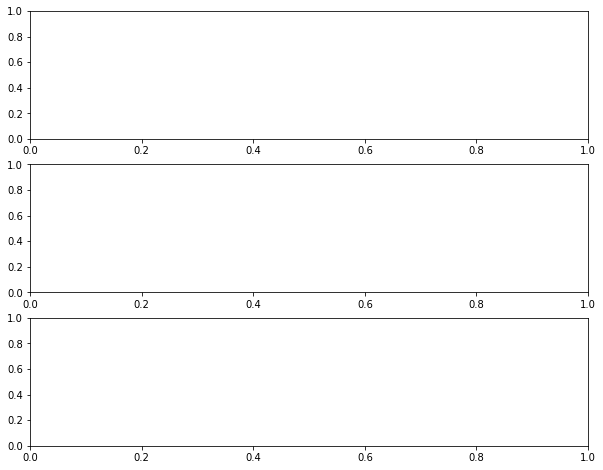

In [73]:
def plot_metrics(model_name, train_metrics, val_metrics, test_metrics, batch_size):
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))

    def f(ax, metrics, title):
        df = pd.DataFrame(metrics, index=np.arange(0, len(metrics) * batch_size, batch_size), columns=['loss', 'auc'])
        ax.set_title(title)
        ax.xaxis.set_major_locator(MultipleLocator(base=batch_size))
        sns.lineplot(data=df['loss'], ax=ax, label='Loss')
        ax.legend(loc=2)
        ax2 = ax.twinx()
        sns.lineplot(data=df['auc'], ax=ax2, color='C1', label='AUC')
        ax2.legend(loc=3)

    f(axs[0], train_metrics, 'Training')
    f(axs[1], test_metrics, 'Validation')
    plt.suptitle(model_name)
plot_metrics('non bayes', train_metrics, val_metrics, test_metrics, 16 )

In [152]:
!pip3 freeze | grep cv


opencv-contrib-python==4.2.0.34
opencv-python==4.2.0.34
# Editable install with no version control (opencv-tests==2.1.4)
-e /Users/ste/ws/build/opencv_tests


In [6]:
import importlib

In [61]:

import model
importlib.reload(model)
from model import BayesConvNet

irs = [[1, 8, 1, 1],[6, 16, 2, 2],[6, 24, 3, 2],[6, 32, 1, 1]]
model = torchvision.models.MobileNetV2(inverted_residual_setting=irs)
print('Total model parameters:', sum(p.numel() for p in model.parameters()))
from torch.hub import load_state_dict_from_url

pretrained_dict = {k: v for k, v in load_state_dict_from_url('https://download.pytorch.org/models/mobilenet_v2-b0353104.pth').items() if k in model.state_dict() and v.shape == model.state_dict()[k].shape}
print('Keys recovered from the pretrained model state that are still compatible:', len(pretrained_dict))

sorted(pretrained_dict.keys())

Total model parameters: 1365032
Keys recovered from the pretrained model state that are still compatible: 33


['classifier.1.bias',
 'classifier.1.weight',
 'features.0.0.weight',
 'features.0.1.bias',
 'features.0.1.num_batches_tracked',
 'features.0.1.running_mean',
 'features.0.1.running_var',
 'features.0.1.weight',
 'features.1.conv.0.0.weight',
 'features.1.conv.0.1.bias',
 'features.1.conv.0.1.num_batches_tracked',
 'features.1.conv.0.1.running_mean',
 'features.1.conv.0.1.running_var',
 'features.1.conv.0.1.weight',
 'features.1.conv.2.num_batches_tracked',
 'features.2.conv.0.1.num_batches_tracked',
 'features.2.conv.1.1.num_batches_tracked',
 'features.2.conv.3.num_batches_tracked',
 'features.3.conv.0.1.num_batches_tracked',
 'features.3.conv.1.1.num_batches_tracked',
 'features.3.conv.3.num_batches_tracked',
 'features.4.conv.0.1.num_batches_tracked',
 'features.4.conv.1.1.num_batches_tracked',
 'features.4.conv.3.num_batches_tracked',
 'features.5.conv.0.1.num_batches_tracked',
 'features.5.conv.1.1.num_batches_tracked',
 'features.5.conv.3.num_batches_tracked',
 'features.6.conv.

In [64]:
import torchvision

irs = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

model = torchvision.models.MobileNetV2(inverted_residual_setting=irs, width_mult=.7)
print('Total model parameters:', sum(p.numel() for p in model.parameters()))

model = torchvision.models.mobilenet_v2(inverted_residual_setting=irs, pretrained=True)
print('Total model parameters:', sum(p.numel() for p in model.parameters()))

Total model parameters: 1478312


RuntimeError: Error(s) in loading state_dict for MobileNetV2:
	Missing key(s) in state_dict: "features.10.0.weight", "features.10.1.weight", "features.10.1.bias", "features.10.1.running_mean", "features.10.1.running_var". 
	Unexpected key(s) in state_dict: "features.11.conv.0.0.weight", "features.11.conv.0.1.weight", "features.11.conv.0.1.bias", "features.11.conv.0.1.running_mean", "features.11.conv.0.1.running_var", "features.11.conv.0.1.num_batches_tracked", "features.11.conv.1.0.weight", "features.11.conv.1.1.weight", "features.11.conv.1.1.bias", "features.11.conv.1.1.running_mean", "features.11.conv.1.1.running_var", "features.11.conv.1.1.num_batches_tracked", "features.11.conv.2.weight", "features.11.conv.3.weight", "features.11.conv.3.bias", "features.11.conv.3.running_mean", "features.11.conv.3.running_var", "features.11.conv.3.num_batches_tracked", "features.12.conv.0.0.weight", "features.12.conv.0.1.weight", "features.12.conv.0.1.bias", "features.12.conv.0.1.running_mean", "features.12.conv.0.1.running_var", "features.12.conv.0.1.num_batches_tracked", "features.12.conv.1.0.weight", "features.12.conv.1.1.weight", "features.12.conv.1.1.bias", "features.12.conv.1.1.running_mean", "features.12.conv.1.1.running_var", "features.12.conv.1.1.num_batches_tracked", "features.12.conv.2.weight", "features.12.conv.3.weight", "features.12.conv.3.bias", "features.12.conv.3.running_mean", "features.12.conv.3.running_var", "features.12.conv.3.num_batches_tracked", "features.13.conv.0.0.weight", "features.13.conv.0.1.weight", "features.13.conv.0.1.bias", "features.13.conv.0.1.running_mean", "features.13.conv.0.1.running_var", "features.13.conv.0.1.num_batches_tracked", "features.13.conv.1.0.weight", "features.13.conv.1.1.weight", "features.13.conv.1.1.bias", "features.13.conv.1.1.running_mean", "features.13.conv.1.1.running_var", "features.13.conv.1.1.num_batches_tracked", "features.13.conv.2.weight", "features.13.conv.3.weight", "features.13.conv.3.bias", "features.13.conv.3.running_mean", "features.13.conv.3.running_var", "features.13.conv.3.num_batches_tracked", "features.14.conv.0.0.weight", "features.14.conv.0.1.weight", "features.14.conv.0.1.bias", "features.14.conv.0.1.running_mean", "features.14.conv.0.1.running_var", "features.14.conv.0.1.num_batches_tracked", "features.14.conv.1.0.weight", "features.14.conv.1.1.weight", "features.14.conv.1.1.bias", "features.14.conv.1.1.running_mean", "features.14.conv.1.1.running_var", "features.14.conv.1.1.num_batches_tracked", "features.14.conv.2.weight", "features.14.conv.3.weight", "features.14.conv.3.bias", "features.14.conv.3.running_mean", "features.14.conv.3.running_var", "features.14.conv.3.num_batches_tracked", "features.15.conv.0.0.weight", "features.15.conv.0.1.weight", "features.15.conv.0.1.bias", "features.15.conv.0.1.running_mean", "features.15.conv.0.1.running_var", "features.15.conv.0.1.num_batches_tracked", "features.15.conv.1.0.weight", "features.15.conv.1.1.weight", "features.15.conv.1.1.bias", "features.15.conv.1.1.running_mean", "features.15.conv.1.1.running_var", "features.15.conv.1.1.num_batches_tracked", "features.15.conv.2.weight", "features.15.conv.3.weight", "features.15.conv.3.bias", "features.15.conv.3.running_mean", "features.15.conv.3.running_var", "features.15.conv.3.num_batches_tracked", "features.16.conv.0.0.weight", "features.16.conv.0.1.weight", "features.16.conv.0.1.bias", "features.16.conv.0.1.running_mean", "features.16.conv.0.1.running_var", "features.16.conv.0.1.num_batches_tracked", "features.16.conv.1.0.weight", "features.16.conv.1.1.weight", "features.16.conv.1.1.bias", "features.16.conv.1.1.running_mean", "features.16.conv.1.1.running_var", "features.16.conv.1.1.num_batches_tracked", "features.16.conv.2.weight", "features.16.conv.3.weight", "features.16.conv.3.bias", "features.16.conv.3.running_mean", "features.16.conv.3.running_var", "features.16.conv.3.num_batches_tracked", "features.17.conv.0.0.weight", "features.17.conv.0.1.weight", "features.17.conv.0.1.bias", "features.17.conv.0.1.running_mean", "features.17.conv.0.1.running_var", "features.17.conv.0.1.num_batches_tracked", "features.17.conv.1.0.weight", "features.17.conv.1.1.weight", "features.17.conv.1.1.bias", "features.17.conv.1.1.running_mean", "features.17.conv.1.1.running_var", "features.17.conv.1.1.num_batches_tracked", "features.17.conv.2.weight", "features.17.conv.3.weight", "features.17.conv.3.bias", "features.17.conv.3.running_mean", "features.17.conv.3.running_var", "features.17.conv.3.num_batches_tracked", "features.18.0.weight", "features.18.1.weight", "features.18.1.bias", "features.18.1.running_mean", "features.18.1.running_var", "features.18.1.num_batches_tracked", "features.10.conv.0.0.weight", "features.10.conv.0.1.weight", "features.10.conv.0.1.bias", "features.10.conv.0.1.running_mean", "features.10.conv.0.1.running_var", "features.10.conv.0.1.num_batches_tracked", "features.10.conv.1.0.weight", "features.10.conv.1.1.weight", "features.10.conv.1.1.bias", "features.10.conv.1.1.running_mean", "features.10.conv.1.1.running_var", "features.10.conv.1.1.num_batches_tracked", "features.10.conv.2.weight", "features.10.conv.3.weight", "features.10.conv.3.bias", "features.10.conv.3.running_mean", "features.10.conv.3.running_var", "features.10.conv.3.num_batches_tracked". 
	size mismatch for features.9.conv.2.weight: copying a param with shape torch.Size([64, 384, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 384, 1, 1]).
	size mismatch for features.9.conv.3.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.9.conv.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.9.conv.3.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.9.conv.3.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).

In [62]:
[[1, 16, 1, 1],
[6, 24, 2, 2],
[6, 32, 3, 2],
[6, 64, 4, 2],
[6, 96, 3, 1],
[6, 160, 3, 2],
[6, 320, 1, 1]]

m = torchvision.models.MobileNetV2()
[x.conv[0][0].in_channels for x in m.features[2:-1]] + [m.features[-1][0].in_channels]
m.features[-1]


ConvBNReLU(
  (0): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)

In [50]:
import torch.optim as optim
from bnn import nn
from sklearn.metrics import roc_auc_score

loss_function = torch.nn.NLLLoss()
kld_function = nn.KLDivergence(number_of_batches=1)
entropy_function = nn.Entropy(dim=-1)

mask = (y > -1)

divergence = kld_function(model)
masked_y = y.type(torch.LongTensor)[mask]
likelihood = torch.stack([
    loss_function(torch.log(pred[mask]), masked_y) for pred in output
]).mean() / model.samples
loss = likelihood + divergence
#loss.backward()

masked_stacked_y = torch.stack([1 - y, y], dim=2)[mask]
auc = np.array([
    roc_auc_score(masked_stacked_y, pred[mask].detach().numpy()) for pred in output
]).mean() / model.samples

# samples x batch_size x 400 x 2, stack over samples, average over samples
agg_preds = torch.stack(output, dim=0).mean(dim=0)
entropy = entropy_function(agg_preds)

logits = agg_preds.argmax(dim=-1)[mask]
accuracy = (logits == y[mask]).float().mean()

loss.item(), entropy.item(), accuracy.item(), auc
# # last layer is log_softmax

torch.Size([16, 400])


(0.34921541810035706,
 0.6536235809326172,
 0.4871794879436493,
 0.1309493477374643)

In [37]:
from model import ConvNet
ConvNet(inverted_residual_setting=irs,                      # major part of the network
                     in_planes=200, out_planes=400, conv_bayes=True,     # our extra convolution
                     num_classes=400, mode=mode, classifier_bayes=False)

ModuleNotFoundError: No module named 'model'

In [29]:
#    t,  c, n, s
irs=[[1, 16, 1, 1],
    [6, 24, 2, 2],
    [6, 32, 3, 2],
    [6, 96, 1, 1]]

import torch.optim as optim
for mode, criterion, desired_transform in zip(['softmax','sigmoid'], 
                                       [nn.NLLLoss(), nn.MSELoss()],
                                       [lambda x: x.type(torch.LongTensor), lambda x: torch.stack([1-x, x], dim=2)]):
    
    # Initialize model
    model = conv_net(inverted_residual_setting=irs,                      # major part of the network
                     in_planes=200, out_planes=400, conv_bayes=True,     # our extra convolution
                     num_classes=400, mode=mode, classifier_bayes=False) # classifier parameters
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
    
    # Training loop example
    X, y = iter(train_loader).next()
    mask = (y > -1)   
    stacked_y = torch.stack([1-y, y], dim=2)
    
    # Get prediction
    output = model(X)
    
    # Calculate loss
    loss = criterion(output[mask], desired_transform(y)[mask])
    print('Loss:', loss.item())
    print('AUC:', roc_auc_score(stacked_y[mask], output[mask].detach().numpy()))
    
    # Calculate error contribution
    loss.backward()
    
    # Update the weights
    optimizer.zero_grad()
    optimizer.step()

AttributeError: module 'bnn.nn' has no attribute 'NLLLoss'

# Chooose one

In [43]:
print(X.shape)

torch.Size([16, 3, 240, 320])


In [19]:
from datetime import datetime as dt
dt.now().strftime("%m%d%H")

'120916'

In [6]:


irs=[[1, 16, 1, 1],
    [6, 24, 2, 2],
    [6, 32, 3, 2],
    [6, 96, 1, 1]]
model = torchvision.models.MobileNetV2(num_classes=800)

display(model.features[-2:], model.classifier)
model.features[-1][0].out_channels

Sequential(
  (17): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): ConvBNReLU(
        (0): Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
        (1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(960, 320, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (18): ConvBNReLU(
    (0): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=800, bias=True)
)

1280

In [15]:
import importlib
import bnn
importlib.reload(bnn)
from bnn import nn as bnn_layers

from sklearn.metrics import roc_auc_score

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

from torch.hub import load_state_dict_from_url
class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)
    
class bayes_conv_net(bnn_layers.BayesianNetworkModule, torchvision.models.MobileNetV2):
    def __init__(self, irs, 
                 in_planes, out_planes, samples=12,
                 num_classes=400, mode='softmax', bayes_classifier=False,
                 width_mult = 1, round_nearest = 8):
        
        # Call constructor to build most of the newtork
        super(bayes_conv_net, self).__init__(in_channels=3, out_channels=num_classes, # Popped by BNN
                                             inverted_residual_setting=irs, width_mult=width_mult, round_nearest=round_nearest) # Passed to MobileNetV2
        
        assert len(self.features) < 15, 'Non stai passando corretamente i parametri al costruttore MobileNetv2'
        self.samples = samples
        
        pretrained_dict = load_state_dict_from_url('https://download.pytorch.org/models/mobilenet_v2-b0353104.pth',progress=True)
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if
                           k in model_dict and v.shape == model_dict[k].shape}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict, strict=True)
        
        # Redefine last convolutional block of the original mobilenetv2 architechture
        # In this way, we can control the output channels, they are the input channels of our extra convolution
        last_block_in = _make_divisible(irs[-1][1] * width_mult, round_nearest)
        print(last_block_in)
        #last_block_in=320 # last_block_in * samples?
        self.features[-1] = torchvision.models.mobilenet.ConvBNReLU(last_block_in, in_planes, kernel_size=1)
        
        # Add out study bayesian convolutional block
        self.features.add_module('study', bnn_layers.NormalConv2d(in_planes, out_planes, 3, 1, 1, bias=False))
        
        # Redefine 'classifier' block at end of the network
        # In this way, we can control the input channels, they are the output channels of our extra convolution
        linear_layer = bnn_layers.NormalLinear if bayes_classifier else nn.Linear
        self.classifier = nn.Sequential(
            #Flatten(),
            nn.Dropout(0.2),
            linear_layer(out_planes, num_classes)
        )
        
        # Final touch, if the user requested it
        f = lambda x: x.reshape(-1, 400, 2)
        if mode == 'sigmoid':
            print('Logistic function has been appended')
            def f(x):
                x = nn.Sigmoid()(x)
                x = x.reshape(-1, 400, 2)
                return x
        elif mode == 'softmax':
            print('LogSoftmax function has been appended')
            def f(x):
                x = x.reshape(-1, 400, 2)
                x = nn.LogSoftmax(dim=2)(x)
                return x
        else:
            print(f'Mode \'{mode}\' not supported, will perform only reshape')
        self.final_touch = f
        
        print('Total model parameters:', sum(p.numel() for p in self.parameters()))
        #display(self.features[-3:], self.classifier)
        
    def _forward(self, x):
        x = self._forward_impl(x)
        x = self.final_touch(x)
        return x

# Initialize model
irs=[[1, 8, 1, 1],
    [6, 16, 2, 2],
    [6, 24, 3, 2],
    [6, 32, 1, 1]]
model = bayes_conv_net(irs, 
                       in_planes=200, out_planes=200, samples=12,
                       bayes_classifier=False)
X, y = iter(train_loader).next()
display(bayes_conv_net.mro())
model(X)

32
LogSoftmax function has been appended
Total model parameters: 847712


[__main__.bayes_conv_net,
 bnn.nn.container.BayesianNetworkModule,
 torchvision.models.mobilenet.MobileNetV2,
 torch.nn.modules.module.Module,
 object]

0

In [17]:
X, y = iter(train_loader).next()
X.shape

torch.Size([16, 3, 240, 320])

In [ ]:
import importlib
import bnn
importlib.reload(bnn)
from bnn import nn as bnn_layers

irs=[[1, 16, 1, 1],
    [6, 24, 2, 2],
    [6, 32, 3, 2],
    [6, 96, 1, 1]]    

class conv_net(bnn_layers.BayesianNetworkModule, torchvision.models.MobileNetV2):
    def __init__(self, inverted_residual_setting, 
                 in_planes, out_planes, bayes, samples=10,
                 num_classes=400, mode='softmax', width_mult = 1, round_nearest = 8):
        
        # Call constructor to build most of the newtork
        super(conv_net, self).__init__(inverted_residual_setting=inverted_residual_setting, 
                                       width_mult=width_mult, round_nearest=round_nearest)
        self.samples = samples
        self.in_channels = in_channels
        self.out_channels = out_channels

model = conv_net(inverted_residual_setting=irs,
                 in_channels=10, out_channels=10,
                 in_planes=200, out_planes=400, bayes=True)


In [ ]:
import inspect
inspect.getsource(bnn_layers.BayesianNetworkModule).split('\n')

In [ ]:
class A:
    def __init__(self,a):
        pass
class B:
    def __init__(self,b):
        pass
class C(A, B):
    def __init__(self,a,b):
        super(C, self).__init__(a=a, b=b)
        
C('a', 'b')

In [ ]:

#    t,  c, n, s
irs=[[1, 16, 1, 1],
    [6, 24, 2, 2],
    [6, 32, 3, 2],
    [6, 96, 1, 1]]    

# Initialize model
model = torchvision.models.MobileNetV2(inverted_residual_setting=irs, width_mult=1., round_nearest=8)
pretrained_dict = load_state_dict_from_url('https://download.pytorch.org/models/mobilenet_v2-b0353104.pth',progress=True)

model_dict = model.state_dict()
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.shape == model_dict[k].shape}
model_dict.update(pretrained_dict) 
# 3. load the new state dict
model.load_state_dict(model_dict, strict=False)

## Setup

# Training, testing first

In [ ]:
from sklearn.metrics import roc_auc_score
import torch.optim as optim

In [ ]:

# import torch.nn.functional as F

# # optimizer
# optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

# # loss function
# criterion = nn.MSELoss(reduction='mean')


In [ ]:
# load sample batch
# data, target = iter(train_loader).next()
# mask = (target > -1)

# # get prediction
# output = model(data)

# # # compute auc
# auc = roc_auc_score(target[mask], output[mask].detach().numpy())
# display(auc)

# # masked loss
# loss = criterion(output[mask], target[mask])
# display(loss.item())

# # reset and comput gradient
# optimizer.zero_grad()
# loss.backward()

# # update network
# optimizer.step()

In [ ]:
epochs = 1

optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss(reduction='mean')

def get_loss_auc(X,y):
    mask = (y > -1)
    output = model(X)
    auc = roc_auc_score(y[mask], output[mask].detach().numpy())
    loss = criterion(output[mask], y[mask])
    return loss, auc

def show_progress(epoch, t, batch_idx, X, loader, loss, auc):
    print(f'\r{t} Epoch: {epoch + 1} [{batch_idx*len(X)}/{len(loader.dataset)} '+
                  f'({100. * batch_idx / len(loader):.0f}%)]\tLoss: {loss.item():.6f}'+
                  f'\t\tAUC: {auc:.3f}', end='')

train_metrics = []
for epoch in range(epochs):
    model.train()
    try:
        for batch_idx, (X, y) in enumerate(train_loader):
            
            loss, auc = get_loss_auc(X, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_metrics.append([loss.item(), auc])
            
            show_progress(epoch, 'Training', batch_idx, X, train_loader, loss, auc)
            
#             if batch_idx % 1000:
#                 print()
#                 model.eval()
#                 with torch.no_grad():
#                     for batch_idy, (X, y) in enumerate(val_loader):
#                         loss, auc = get_loss_auc(X, y)
#                     show_progress(epoch, 'Validation', batch_idy, X, val_loader, loss, auc)
#                 model.train()
    except KeyboardInterrupt:
        #show_progress(epoch, 'End of training:', batch_idx, X, train_loader, loss, auc)
        print('\nUser stopped the training/validation phase')
    print()
    test_metrics = []
    model.eval() 
    try:
        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(test_loader):
                loss, auc = get_loss_auc(X, y)
                test_metrics.append([loss.item(), auc])
                show_progress(epoch, 'Test', batch_idx, X, test_loader, loss, auc)
    except KeyboardInterrupt:
        print('\nUser stopped the testing phase')
print('End of execution')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

def plot_metrics(model_name, train_metrics, test_metrics):
    fig, axs = plt.subplots(2,1,figsize=(10,8))
    def f(ax, metrics):
        df = pd.DataFrame(metrics, index=np.arange(0,len(metrics)*batch_size, batch_size), columns=['loss', 'auc'])
        ax.set_title('Training')
        ax.xaxis.set_major_locator(MultipleLocator(base=batch_size))
        sns.lineplot(data=df['loss'], ax=ax, label='Loss')
        ax.legend(loc=2)
        ax2 = ax.twinx()
        sns.lineplot(data=df['auc'], ax=ax2, color='C1', label='AUC')
        ax2.legend(loc=3)

    f(axs[0], train_metrics)
    f(axs[1], test_metrics)
    plt.suptitle(model_name)

plot_metrics('Pretrained MobileNetv2', train_metrics, test_metrics)

In [ ]:
import torch
model = torch.load('initial_test');

In [ ]:
#run_cd = ConvDataset(run['image'], labels=run['target_map'], transform=transform)
#run_loader = DataLoader(run_cd, batch_size=batch_size, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt, matplotlib.colors as clr
import seaborn as sns
fig, axs = plt.subplots(figsize=(6,6))
axs.axis('off')
X, y = cd[np.random.choice(len(cd))]
pred_omap = model(X.unsqueeze(0)).squeeze().reshape(20,20).detach().numpy()
def normalized_point(dist, x):
    near_one = dist.flat[np.abs(dist - x).argmin()]
    return (near_one - dist.min())/(dist.max()-dist.min())
cmap = clr.LinearSegmentedColormap.from_list('custom blue', [(0, 'white'), 
                                                             (normalized_point(pred_omap, -1), 'grey'),
                                                             (normalized_point(pred_omap, 0), 'green'), 
                                                             (normalized_point(pred_omap, 1),    'red'),
                                                             (normalized_point(pred_omap, +2), 'grey'),
                                                             (1, 'white')], N=256)
sns.heatmap(data=pred_omap, ax=axs, cmap=cmap, cbar=True)
plt.show()

In [ ]:
# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

In [ ]:
ax.collections[0].__dict__.keys()

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

user_input = 1
while user_input != '0':
    X, y = cd[np.random.choice(len(cd))]
    fig, axs = plt.subplots(1,3, figsize=(20,5))
    axs[0].imshow(_moveaxis(X, 0,-1))
    myColors = ('grey', (0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0))
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    sns.heatmap(data=y.reshape(20,20), ax=axs[1], cmap=cmap, cbar=False)
    
    
    cmap = clr.LinearSegmentedColormap.from_list('custom', ('grey', (0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0)), N=256)

    sns.heatmap(data=model(X.unsqueeze(0)).squeeze().reshape(20,20).detach().numpy(), ax=axs[2], cbar=False, cmap=cmap)
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    user_input = input()

In [2]:
import analyzer, importlib, os
importlib.reload(analyzer)
from IPython.display import Video
points_file = os.path.join(d.path, 'points.json')
with open(points_file) as f:
    points_d = json.load(f)
targets = np.array([(c['x'],c['y']) for c in points_d['targets']])

r = np.random.choice(df[~df['out_of_map']]['run'].unique())
run = df[df['run'] == r].copy()
save_path = os.path.join(d.path,'single_runs',f'omap_{r}.mp4')
analyzer.Animator(run, targets, rate=30, save_path=save_path, model=model)
display(Video(save_path))

NameError: name 'd' is not defined

In [ ]:
for X, y in torch.utils.data.DataLoader(test_loader, batch_size=1, num_workers=0, shuffle=True):
    fig, axs = plt.subplots(1,3, figsize=(20,5))
    axs[0].imshow(_moveaxis(X, 0,-1))
    sns.heatmap(data=y.reshape(20,20), ax=axs[1], cbar=False)
    sns.heatmap(data=model(X.unsqueeze(0)).squeeze().reshape(20,20).detach().numpy(), ax=axs[2], cbar=False)
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    break